# Project: China Scientific Leadership

**Notebook:** Fig2_a_China_US_Parity_by_JIF_threshold.ipynb

**Authors:** Renli Wu, Christopher Esposito, James Evans

**Affiliations:** School of Information Management, Wuhan University / Knowledge Lab, University of Chicago / University of California, Los Angeles

**Date:** 2024-11-29 (UTC)
**Version:** v0.3.0

**Purpose:**
This notebook generates **Figure 2a (Lead Share version)** for the main text, and also produces the **Lead Premium version** (reported as **Fig. S3a** in the Supplementary Information).
Both the Lead Share and Lead Premium versions are equally important for providing complementary perspectives on leadership distribution.
In addition, the notebook can generate the supplementary figure (**Fig. S31**) for extended analysis.


**Inputs:**  
- `data/OpenAlex2023_Paper_Author_Lead_Pro_dataset.csv.gz`

**Outputs:**
- `pics/fig_2_a_lead_share.svg`
- `pics/fig_2_a_lead_premium.svg`

**Notes:**
See `README.md` for details on environment setup, dependencies, and execution order within the full analysis pipeline.


In [1]:
import numpy as np
import pandas as pd
import time

### Load the leadership dataset

In [2]:
%%time
print(time.strftime('%l:%M%p %Z on %b %d, %Y'))
data = pd.read_csv("./data/OpenAlex2023_Paper_Author_Lead_Pro_dataset.csv.gz", compression="gzip")
print(time.strftime('%l:%M%p %Z on %b %d, %Y'), data.shape)
data.head()

 5:13AM CDT on Sep 17, 2025


<timed exec>:2: DtypeWarning: Columns (9,14,15) have mixed types. Specify dtype option on import or set low_memory=False.


 5:15AM CDT on Sep 17, 2025 (42995311, 22)
CPU times: user 2min 1s, sys: 10.2 s, total: 2min 11s
Wall time: 2min 12s


,paperId,authorId,publication_year,Lead_Pro,region,China_US,China_EU+,China_UK,US_EU+,UK_EU+,...,China_BeltRoad_HighIncome,China_BeltRoad_LowIncome,US_BeltRoad_HighIncome,US_BeltRoad_LowIncome,jif_2021,jif_mid,11_technical_area,fos_6,Honorary_authors,Matched_in_WOS
0,W3135965258,A5021665664,2021,0.155624,East Asia,False,False,False,False,False,...,False,False,NaN,NaN,1-5,3.0,DIS;EG;HPC;MAT;SC,earth & life science;chemistry & materials sci...,False,True
1,W3135965258,A5032223512,2021,0.263628,East Asia,False,False,False,False,False,...,False,False,NaN,NaN,1-5,3.0,DIS;EG;HPC;MAT;SC,earth & life science;chemistry & materials sci...,False,True
2,W3135978430,A5058653785,2021,0.300942,EU+,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True
3,W3135978430,A5062473161,2021,0.689903,EU+,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True
4,W3135978430,A5006524513,2021,0.242909,Latin America,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True


In [3]:
### Main text - Fig 2(a) China-US Lead Parity By Journal Impact Factor

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from sklearn.linear_model import LinearRegression
from scipy.stats import t as student_t

In [5]:
# ---------- Parameters ----------
c1, c2 = "China", "U.S."
lead_threshold = 0.65
pair_col = f"{c1.replace('.', '')}_{c2.replace('.', '')}"
cols_needed = ["paperId","authorId","Lead_Pro","publication_year","region","jif_2021","jif_mid"]
year_tuple_list   = [(y, y) for y in range(2010, 2024)]
min_pub_per_year  = 200
future_years_grid = np.arange(2024, 2031).reshape(-1, 1)
conf_level        = 0.95

# Colors
share_color   = "#f07167"
premium_color = "#0077b6"

In [6]:
# ---------- Helpers ---------
def _bins(n=20):
    return np.linspace(0, 1, n+1)

def midpoint(iv: pd.Interval) -> float:
    return float(iv.mid)

def find_bounds_intersection_interval(year_grid, equal_line, X, x_mean, t_val, st_err, model):
    """Return [lower, upper] years where CI(mean prediction) encloses equal_line; else ("Never","Never")."""
    year_grid = np.asarray(year_grid, dtype=float).reshape(-1, 1)
    y_hat = model.predict(year_grid)
    n = len(X)
    sxx = float(np.sum((X - x_mean)**2))
    se_mean = st_err * np.sqrt(1/n + (year_grid - x_mean)**2 / sxx)

    lo = (y_hat - t_val * se_mean).ravel()
    hi = (y_hat + t_val * se_mean).ravel()
    mask = (lo <= equal_line) & (hi >= equal_line)
    if np.any(mask):
        idx = np.where(mask)[0]
        return int(year_grid[idx[0], 0]), int(year_grid[idx[-1], 0])
    return "Never", "Never"

def extract_start(s):
    """Sort key for labels like '0-1', '1-2', … ; returns +inf for 'inf'."""
    start_str = str(s).split('-')[0]
    return float('inf') if start_str in {'inf', 'Inf', 'INF'} else float(start_str)

In [7]:
# ---------- Data: subset to the target country pair ----------
obs = (
    data.loc[data[pair_col] == True, cols_needed]
        .drop_duplicates(["paperId","authorId","region"])
        .copy()
)
jif_thds = np.sort(obs["jif_mid"].dropna().unique())

# ---------- 1) Build df_slope over years × JIF bins ----------
slope_rows = []
val_bins = _bins(20)

for (st_year, end_year) in year_tuple_list:
    for jf in jif_thds:
        sub = obs[
            (obs["publication_year"].between(st_year, end_year))
            & (obs["jif_mid"] == jf)
        ].copy()
        pub_count = sub["paperId"].nunique()
        if pub_count <= min_pub_per_year:
            continue

        sub["val_bins"] = pd.cut(sub["Lead_Pro"], bins=val_bins, include_lowest=True)

        # >>> Fix FutureWarning: pass observed=True <<<
        sta = (
            sub.groupby(["region","val_bins"], observed=True)
               .size().rename("count").reset_index()
        )
        sta["val_midpoints"] = sta["val_bins"].apply(midpoint).astype(float)

        wide = (
            sta.pivot(index="val_midpoints", columns="region", values="count")
               .reindex(columns=[c1, c2])
               .fillna(0.0)
               .reset_index()
        )

        # Lead/muscle counts by threshold
        c1_lead  = wide.loc[wide["val_midpoints"] >  lead_threshold, c1].sum()
        c2_lead  = wide.loc[wide["val_midpoints"] >  lead_threshold, c2].sum()
        c1_musc  = wide.loc[wide["val_midpoints"] <= lead_threshold, c1].sum()
        c2_musc  = wide.loc[wide["val_midpoints"] <= lead_threshold, c2].sum()

        denom_lead = c1_lead + c2_lead
        denom_musc = c1_musc + c2_musc
        c1_lead_share = (c1_lead / denom_lead) if denom_lead > 0 else np.nan
        lead_premium  = (c1_lead / denom_lead - c1_musc / denom_musc) if (denom_lead > 0 and denom_musc > 0) else np.nan

        slope_rows.append([c1, c2, jf, c1_lead_share, lead_premium, st_year, end_year, pub_count])

df_slope = pd.DataFrame(
    slope_rows,
    columns=["c1","c2","jif_thd","c1_lead_share","lead_premium","st_year","end_year","pub_num"]
)
df_slope["year"] = (df_slope["st_year"] + df_slope["end_year"]) / 2

# Keep JIF bins with enough data across time
df_draw = df_slope[df_slope["pub_num"] >= 300].sort_values(by="st_year")

In [8]:
# ---------- 2) Regression & parity table by JIF (for two metrics) ----------
def parity_table_by_jif(df_draw, metric_col, equal_line, min_year=2010):
    """
    Compute:
      - mean-line parity year (catch-up)
      - CI-interval parity [lower, upper] with legend text rules.
    """
    recs = []
    for jf in np.sort(df_draw['jif_thd'].unique()):
        cur = df_draw[(df_draw['jif_thd'] == jf) & (df_draw[metric_col].notna()) & (df_draw["year"] >= min_year)]
        if cur.shape[0] < 3:
            continue

        X = cur['year'].to_numpy().reshape(-1,1)
        Y = cur[metric_col].to_numpy().reshape(-1,1)
        model = LinearRegression().fit(X, Y)

        # CI for current data
        y_pred = model.predict(X)
        resid  = Y - y_pred
        n      = len(X)
        if n <= 2:
            continue

        sse    = float(np.sum(resid**2))
        st_err = np.sqrt(sse / (n - 2))
        x_mean = float(np.mean(X))
        sxx    = float(np.sum((X - x_mean)**2))
        t_val  = float(student_t.ppf((1 + conf_level) / 2, df=n - 2))

        # CI parity interval on an extended grid
        lower_int, upper_int = find_bounds_intersection_interval(
            year_grid=np.arange(max(min_year, 2015), 2500),
            equal_line=equal_line, X=X, x_mean=x_mean, t_val=t_val, st_err=st_err, model=model
        )

        # Mean-line parity (solve a + b*year = equal_line)
        b = float(model.coef_.ravel()[0])
        a = float(model.intercept_.ravel()[0])
        catch_up = int(np.round((equal_line - a)/b)) if not np.isclose(b, 0) else "Never"
        if isinstance(catch_up, int) and (catch_up < 2000 or catch_up > 3000):
            catch_up = "Never"

        # Legend-like text (sorted interval; if hi>2200 → "after lo")
        if upper_int == lower_int == "Never":
            legend_text = "Never Parity"
        elif upper_int != "Never" and lower_int == "Never":
            legend_text = f"Parity after {upper_int}"
        elif upper_int == lower_int:
            legend_text = f"Parity {upper_int}"
        else:
            lo, hi = sorted([lower_int, upper_int])
            legend_text = f"Parity after {lo}" if hi > 2200 else f"Parity {lo}-{hi}"

        recs.append([metric_col, jf, catch_up, upper_int, lower_int, legend_text])
    out = pd.DataFrame(recs, columns=["type","jif_thd","catch_up_year","upper_catch_up_year","lower_catch_up_year","legend_text"])
    return out

df_cap_share = parity_table_by_jif(df_draw, metric_col="c1_lead_share", equal_line=0.5, min_year=2010)
df_cap_prem  = parity_table_by_jif(df_draw, metric_col="lead_premium",  equal_line=0.0, min_year=2010)
df_cap = pd.concat([df_cap_share, df_cap_prem], ignore_index=True)

# ---------- 3) Prepare plotting fields (handle "Never" as +Inf placeholder) ----------
df_cap["label"]        = df_cap["catch_up_year"].astype(str)
df_cap["upper_label"]  = df_cap["upper_catch_up_year"].astype(str)
df_cap["lower_label"]  = df_cap["lower_catch_up_year"].astype(str)

never_year = max(
    pd.to_numeric(df_cap['upper_catch_up_year'], errors='coerce').max(),
    pd.to_numeric(df_cap['lower_catch_up_year'], errors='coerce').max(),
    pd.to_numeric(df_cap['catch_up_year'],        errors='coerce').max()
)
never_year = int((never_year if np.isfinite(never_year) else 2100) + 50)

# Replace "Never" with placeholder for NUMERIC plotting only
dfp = df_cap.copy()
for col in ['upper_catch_up_year', 'lower_catch_up_year', 'catch_up_year']:
    dfp.loc[dfp[col] == "Never", col] = never_year
# ensure numeric types after replacement
for col in ['upper_catch_up_year', 'lower_catch_up_year', 'catch_up_year']:
    dfp[col] = pd.to_numeric(dfp[col], errors='coerce')

# X tick labels from JIF bins (use jif_2021 labels; fallback to jif_mid)
labels_source = obs["jif_2021"].dropna().unique() if obs["jif_2021"].notna().any() else obs["jif_mid"].dropna().unique()
labels_sorted = [n for n in sorted(labels_source, key=extract_start)]
x_tick_labels = [str(x) for x in labels_sorted]

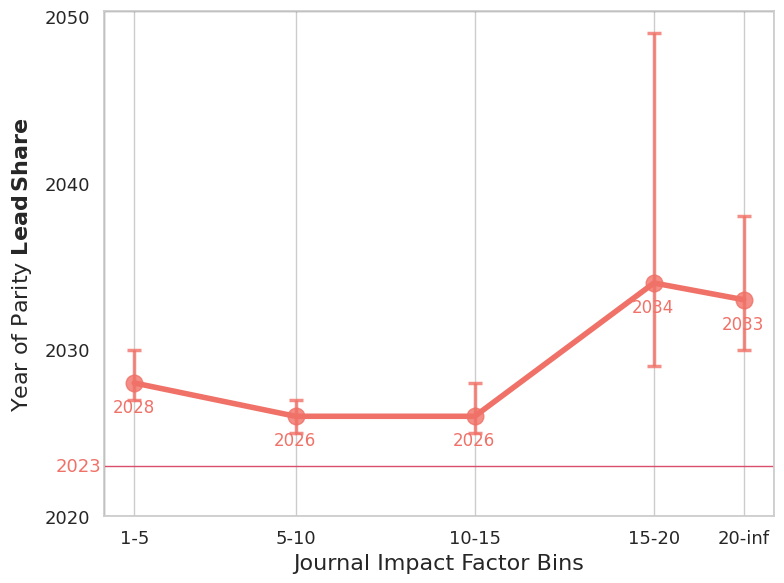

In [9]:
# ---------- 4) Plotting (two separate figures) ----------
sns.set_theme(style="whitegrid")

# --- Figure 2.1: Lead Share parity vs JIF ---
fig, ax2 = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')

d2 = dfp[dfp['type'] == 'c1_lead_share'].copy().sort_values('jif_thd')

# Line
sns.lineplot(x="jif_thd", y="catch_up_year", data=d2, ax=ax2, color=share_color, linewidth=4)

# Error bars
catch = d2['catch_up_year'].astype(float).values
lo    = d2['lower_catch_up_year'].astype(float).values
hi    = d2['upper_catch_up_year'].astype(float).values
yerr_lower = np.maximum(catch - lo, 0.0)
yerr_upper = np.maximum(hi - catch, 0.0)
yerr = np.vstack([yerr_lower, yerr_upper])

ax2.errorbar(x=d2['jif_thd'].values, y=catch,
             yerr=yerr, fmt='o', ecolor=share_color, barsabove=True,
             elinewidth=2.5, capthick=2.5, alpha=0.8,
             color=share_color, capsize=5, markersize=12)

# Point labels
for _, row in d2.iterrows():
    ax2.text(row['jif_thd']-0.02, float(row['catch_up_year']) - 2,
             f"{row['label']}", ha='center', va='bottom',
             color=share_color, fontsize=12)

# Reference line & cosmetics
ax2.axhline(2023, color='#DB4D6D', linestyle='-', linewidth=1)
ax2.annotate('2023', xy=(0.80, 2023), xycoords=('data','data'),
             va='center', ha='left', color=share_color, fontsize=13)
ax2.yaxis.grid(False)
ax2.set_ylabel(r"Year of Parity $\bf{Lead}\,\bf{Share}$",
               fontsize=16, rotation=90, labelpad=8)
ax2.set_xlabel("Journal Impact Factor Bins", fontsize=16)

# Y ticks
ax2.set_yticks(list(range(2020, 2060, 10)))
for lbl in ax2.get_yticklabels():
    lbl.set_fontsize(13)

# X ticks
ax2.set_xticks(jif_thds)
ax2.set_xticklabels(x_tick_labels, fontsize=13)

# Border rectangle
x0, x1 = ax2.get_xlim()
y0, y1 = ax2.get_ylim()
rect2 = patches.Rectangle((x0, y0), x1 - x0, y1 - y0,
                          linewidth=1, edgecolor='black', facecolor='none', alpha=0.5)
ax2.add_patch(rect2)
plt.savefig(f"./pics/fig_2_a_lead_share.svg",
            facecolor='white', bbox_inches='tight', format="svg", dpi=300)
plt.tight_layout()
plt.show()

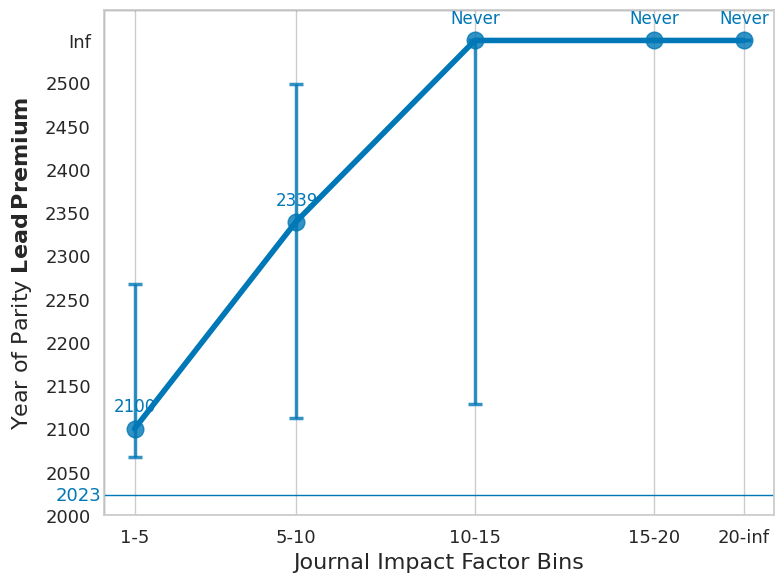

In [10]:

# --- Figure 2.2: Lead Premium parity vs JIF ---
fig, ax1 = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')

d1 = dfp[dfp['type'] == 'lead_premium'].copy().sort_values('jif_thd')

sns.lineplot(x="jif_thd", y="catch_up_year", data=d1, ax=ax1, color=premium_color, linewidth=4)

# Error bars
catch = d1['catch_up_year'].astype(float).values
lo    = d1['lower_catch_up_year'].astype(float).values
hi    = d1['upper_catch_up_year'].astype(float).values
yerr_lower = np.maximum(catch - lo, 0.0)
yerr_upper = np.maximum(hi - catch, 0.0)
yerr = np.vstack([yerr_lower, yerr_upper])

ax1.errorbar(x=d1['jif_thd'].values, y=catch,
             yerr=yerr, fmt='o', ecolor=premium_color, barsabove=True,
             elinewidth=2.5, capthick=2.5, alpha=0.8,
             color=premium_color, capsize=5, markersize=12)

# Point labels
for _, row in d1.iterrows():
    ax1.text(row['jif_thd']+0.02, float(row['catch_up_year']) + 15,
             f"{row['label']}", ha='center', va='bottom',
             color=premium_color, fontsize=12)

ax1.axhline(2023, color=premium_color, linestyle='-', linewidth=1)
ax1.annotate('2023', xy=(0.80, 2023), xycoords=('data','data'),
             va='center', ha='left', color=premium_color, fontsize=13)
ax1.yaxis.grid(False)
ax1.set_ylabel(r"Year of Parity $\bf{Lead}\,\bf{Premium}$",
               fontsize=16, rotation=90, labelpad=8)
ax1.set_xlabel("Journal Impact Factor Bins", fontsize=16)

# Y ticks with "Inf" at placeholder
a1_yticks = list(range(2000, int(never_year) + 20, 50))
a1_yticks = a1_yticks[:-1] + [never_year]
ax1.set_yticks(a1_yticks)
ax1.set_ylim(2000, int(never_year) + 35)
a1_ytick_labels = [str(yt) for yt in a1_yticks[:-1]] + ['Inf']
ax1.set_yticklabels(a1_ytick_labels)
for lbl in ax1.get_yticklabels():
    lbl.set_fontsize(13)

# X ticks
ax1.set_xticks(jif_thds)
ax1.set_xticklabels(x_tick_labels, fontsize=13)

# Border rectangle
x0, x1 = ax1.get_xlim()
y0, y1 = ax1.get_ylim()
rect1 = patches.Rectangle((x0, y0), x1 - x0, y1 - y0,
                          linewidth=1, edgecolor='black', facecolor='none', alpha=0.5)
ax1.add_patch(rect1)
plt.tight_layout()
plt.savefig(f"./pics/fig_2_a_lead_premium.svg",
            facecolor='white', bbox_inches='tight', format="svg", dpi=300)
plt.show()